##### Измененный пример из туториала Copyright 2019 The TensorFlow Authors.

# # ПРОВЕРКА 2D МОДЕЛЕЙ НА КОТИКАХ И СОБАЧКАХ

In [1]:
import tensorflow as tf

In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
gpu_device = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)


## Download the Oxford-IIIT Pets dataset

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    input_mask = tf.reshape(input_mask, tf.shape(input_mask)[:-1])
    tmp = []
    # NCR/NET
    ttt = input_mask
    tmp.append(tf.where(ttt == 0.0, 1.0, 0.0))
    # peritumoral edema
    ttt = input_mask
    tmp.append(tf.where(ttt == 1.0, 1.0, 0.0))
    # GD-enhancing tumor
    ttt = input_mask
    tmp.append(tf.where(ttt == 2.0, 1.0, 0.0))
    input_mask = tf.stack(tmp,axis=-1) 
    return input_image, input_mask

In [5]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 




In [8]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(128, 128, 3)
(128, 128, 3)


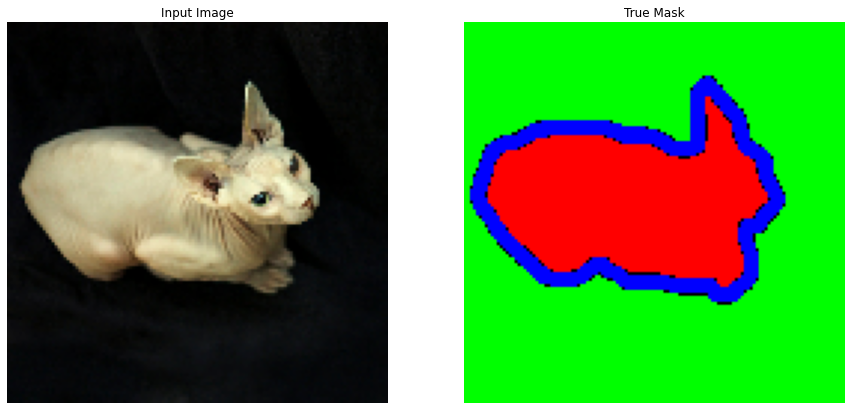

(128, 128, 3)


In [11]:
for image, mask in train.take(1):
    print(image.shape)
    print(mask.shape)
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])
print(sample_mask.shape)

## Тренеруем модель


In [12]:
from models.model_UNet2d import Model2DUnet
from models.model_MultiReaUNet2d import Model2DMultiResUnet

# Model2DMultiResUnet or Model2DUnet
Model = Model2DUnet

manager_model = Model(depth=5, start_val_filters=32, input_img_shape=(128,128), n_classes=3, n_channels=3,
                                    initial_learning_rate=1.0)
model = manager_model.model

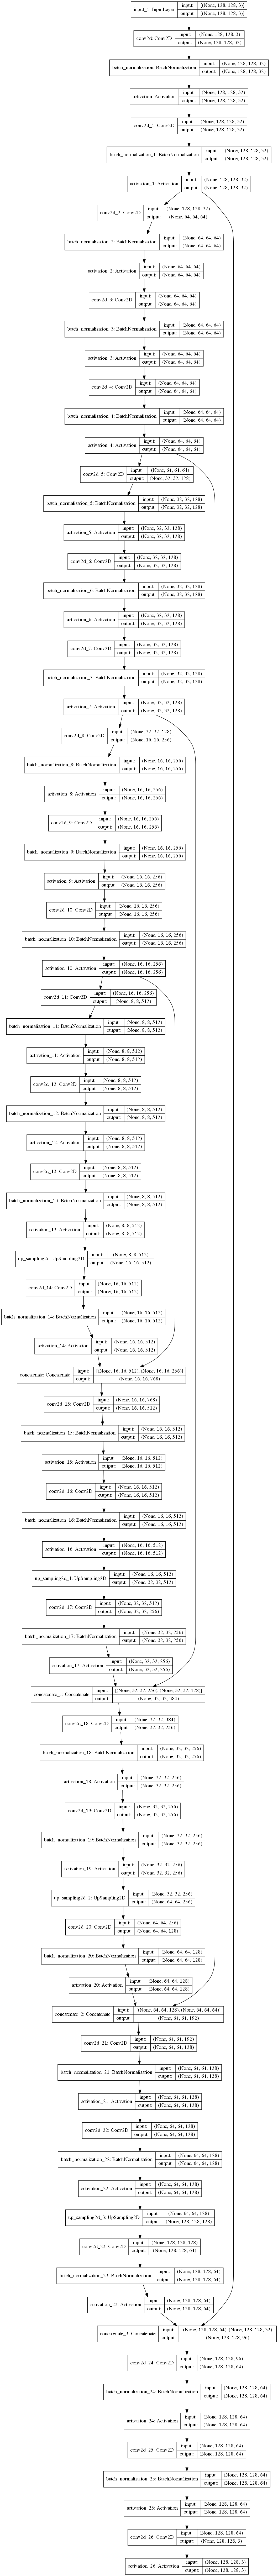

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [15]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            print(image.shape)
            print(mask.shape)
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

(16, 128, 128, 3)
(16, 128, 128, 3)


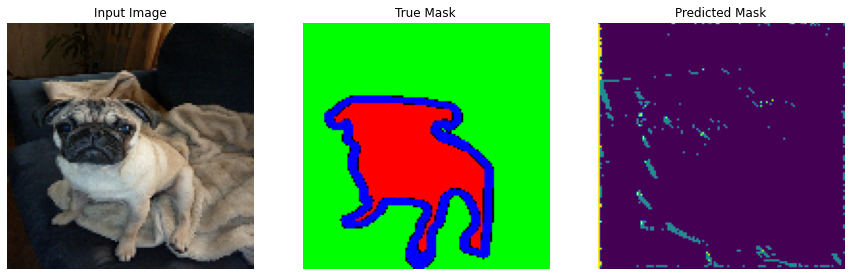

In [16]:
show_predictions(train_dataset)

In [17]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [18]:
EPOCHS = 20
VAL_SUBSPLITS = 20
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          verbose=1)

Epoch 1/20
230/230 [==============================] - 140s 562ms/step - loss: 0.5784 - jaccard_coefficient: 0.5681 - label_0_jaccard_coef: 0.3455 - label_1_jaccard_coef: 0.6197 - label_2_jaccard_coef: 0.1573 - val_loss: 0.5641 - val_jaccard_coefficient: 0.6976 - val_label_0_jaccard_coef: 0.3343 - val_label_1_jaccard_coef: 0.6735 - val_label_2_jaccard_coef: 0.1650
Epoch 2/20
230/230 [==============================] - 126s 549ms/step - loss: 0.4232 - jaccard_coefficient: 0.7762 - label_0_jaccard_coef: 0.4653 - label_1_jaccard_coef: 0.7539 - label_2_jaccard_coef: 0.2904 - val_loss: 0.4089 - val_jaccard_coefficient: 0.7921 - val_label_0_jaccard_coef: 0.4868 - val_label_1_jaccard_coef: 0.7561 - val_label_2_jaccard_coef: 0.3153
Epoch 3/20
230/230 [==============================] - 128s 556ms/step - loss: 0.3714 - jaccard_coefficient: 0.8166 - label_0_jaccard_coef: 0.5072 - label_1_jaccard_coef: 0.7963 - label_2_jaccard_coef: 0.3293 - val_loss: 0.3559 - val_jaccard_coefficient: 0.8269 - val_l

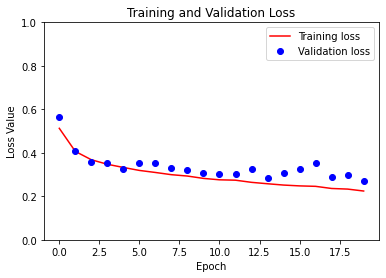

In [19]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Проверяем готовую модель

(16, 128, 128, 3)
(16, 128, 128, 3)


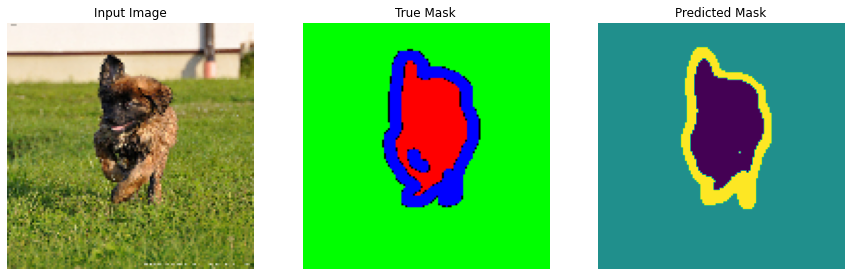

(16, 128, 128, 3)
(16, 128, 128, 3)


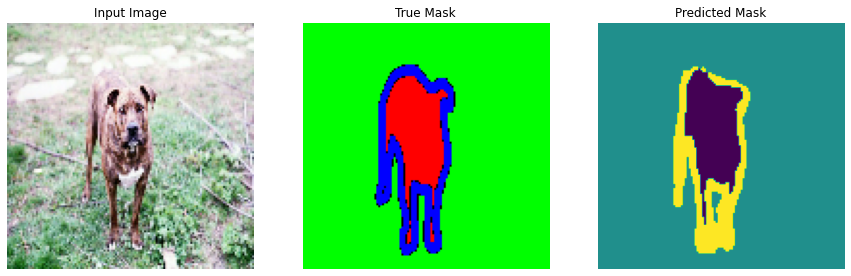

(16, 128, 128, 3)
(16, 128, 128, 3)


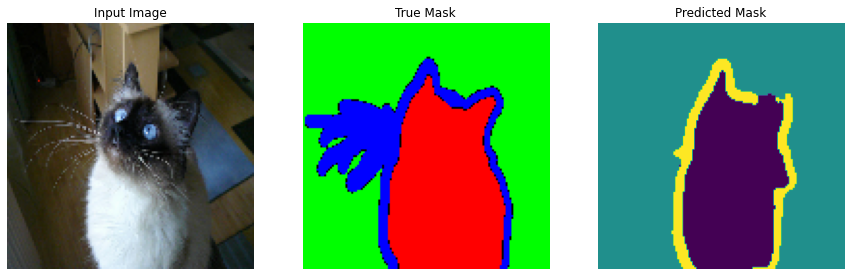

In [20]:
show_predictions(test_dataset, 3)